# Final Evaluation Notebook

In [1]:
# if using google colab, uncomment the following line to install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost tabpfn catboost
!pip install tensorflow scikeras keras scikit-optimize
!pip install pytorch-lightning
!pip install pytorch-tabnet

In [2]:
import torch
from torch import nn
import pytorch_lightning as pl
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, make_scorer
from scipy.stats import kendalltau
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import EarlyStopping

In [2]:
# connect google drive (if using collab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Loading Dataset
#data = pd.read_csv("/content/drive/MyDrive/ECE324_Project/Model/dataset.csv") # change path for your env
data = pd.read_csv("database.csv") # change path for your env
#data.head()
from smartstudy.config import PROCESSED_DATA_DIR

data_path = PROCESSED_DATA_DIR / "processed_data.csv"
data = pd.read_csv(data_path)

In [13]:
# Data Splitting & Normalization
scaler = StandardScaler()
input = data.drop(columns=['GPA'], errors='ignore')
input = scaler.fit_transform(input)
labels = data['GPA']
X_train, X_temp, Y_train, Y_temp = train_test_split(input, labels, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# for models, that don't need x_val for epochs:
X_train_val = np.concatenate([X_train, X_val])
Y_train_val = np.concatenate([Y_train, Y_val])

# 1. Forest Regressor Models

## 1.1 Random Forest

In [14]:
# Random Forest Regression
reg_model = RandomForestRegressor(n_estimators=20, random_state=42)
reg_model.fit(X_train_val, Y_train_val)
reg_pred = reg_model.predict(X_test)

#evaluation
mae_model1 = mean_absolute_error(Y_test, reg_pred)
mse_model1 = mean_squared_error(Y_test, reg_pred)
rmse_model1 = np.sqrt(mse_model1)
r2_model1 = reg_model.score(X_test, Y_test)

print('Mean Absolute Error', mae_model1)
print('Mean Squared Error:', mse_model1)
print('Root Mean Squared Error:', rmse_model1)
print('R2 Score:', r2_model1)

Mean Absolute Error 0.19523669529648816
Mean Squared Error: 0.059958813401757155
Root Mean Squared Error: 0.24486488805412088
R2 Score: 0.9257559817459035


## 1.2 CatBoost

In [15]:
# Train CatBoost
cat_model = CatBoostRegressor(random_state=42, verbose=0)
cat_model.fit(X_train_val, Y_train_val)
cat_pred = cat_model.predict(X_test)

# evaluation
mae_model2 = mean_absolute_error(Y_test, cat_pred)
mse_model2 = mean_squared_error(Y_test, cat_pred)
rmse_model2 = np.sqrt(mse_model2)
r2_model2 = cat_model.score(X_test, Y_test)

print('Mean Absolute Error', mae_model2)
print('Mean Squared Error:', mse_model2)
print('Root Mean Squared Error:', rmse_model2)
print('R2 Score:', r2_model2)

Mean Absolute Error 0.16036260410018588
Mean Squared Error: 0.041892672044196284
Root Mean Squared Error: 0.2046769944185137
R2 Score: 0.948126386572703


## 1.3 XGBoost (tuned with Bayesian Optimization)

In [16]:
# use best params from bayesian opt
best_params = {
    'gamma': 0.06,
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 8,
    'n_estimators': 228
}

xgb_model = XGBRegressor(objective='reg:squarederror',
                                    random_state=42,
                                    **best_params)
xgb_model.fit(X_train_val, Y_train_val)
xgb_pred = xgb_model.predict(X_test)

# evaluation
mae_model3 = mean_absolute_error(Y_test, xgb_pred)
mse_model3 = mean_squared_error(Y_test, xgb_pred)
rmse_model3 = np.sqrt(mse_model3)
r2_model3 = xgb_model.score(X_test, Y_test)

print('Mean Absolute Error', mae_model3)
print('Mean Squared Error:', mse_model3)
print('Root Mean Squared Error:', rmse_model3)
print('R2 Score:', r2_model3)

Mean Absolute Error 0.16118910024253033
Mean Squared Error: 0.04254371646534506
Root Mean Squared Error: 0.2062612820316626
R2 Score: 0.9473202306275524


# 2. Neural Network Models

## 2.1 MLP Model

In [17]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import kendalltau

# Convert X_train and Y_train to NumPy arrays if they are not already
X_np = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
Y_np = Y_train.to_numpy() if hasattr(Y_train, "to_numpy") else Y_train

# Define the MLP model
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # Two hidden layers with 64 and 32 neurons
    activation='relu',  # Rectified Linear Unit activation function
    solver='adam',  # Adam optimizer
    max_iter=50,  # Maximum number of iterations (epochs)
    random_state=42,  # Random state for reproducibility
)

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R2': r2_score
}

all_scores = {metric: [] for metric in scoring_metrics}

for train_idx, val_idx in kf.split(X_np):
    X_cv_train, X_cv_val = X_np[train_idx], X_np[val_idx]
    Y_cv_train, Y_cv_val = Y_np[train_idx], Y_np[val_idx]

    mlp_model.fit(X_cv_train, Y_cv_train)
    y_cv_pred = mlp_model.predict(X_cv_val)

    for metric_name, metric_func in scoring_metrics.items():
        all_scores[metric_name].append(metric_func(Y_cv_val, y_cv_pred))

mean_scores = {metric: np.mean(scores) for metric, scores in all_scores.items()}

# Print cross-validation results
print('Cross-Validation Results:')
for metric, score in mean_scores.items():
    print(f'{metric}: {score}')

# Train the model on the full training set
mlp_model.fit(X_np, Y_np)

# Predict on the test set
mlp_pred = mlp_model.predict(X_test)

# Evaluate the model
mae_model4 = mean_absolute_error(Y_test, mlp_pred)
mse_model4 = mean_squared_error(Y_test, mlp_pred)
rmse_model4 = np.sqrt(mse_model4)
r2_model4 = r2_score(Y_test, mlp_pred)

print('Mean Absolute Error', mae_model4)
print('Mean Squared Error:', mse_model4)
print('Root Mean Squared Error:', rmse_model4)
print('R2 Score:', r2_model4)

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.wa

Cross-Validation Results:
MSE: 0.06351011839297029
MAE: 0.20225902471231438
R2: 0.9236260313684952
Mean Absolute Error 0.1805893989789024
Mean Squared Error: 0.05166933769848505
Root Mean Squared Error: 0.22730890369381718
R2 Score: 0.9360204274631129


c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


## 2.2. TabNet

In [18]:
from pytorch_tabnet.tab_model import TabNetRegressor

# Reshape labels for TabNet compatibility
Y_train_tabnet = Y_train.values.reshape(-1, 1)  # Reshape to 2D
Y_val_tabnet = Y_val.values.reshape(-1, 1)      # Reshape to 2D

# Instantiate TabNet model
tabnet_model = TabNetRegressor()
tabnet_model.fit(
    X_train, Y_train_tabnet,  # Use reshaped Y_train
    eval_set=[(X_val, Y_val_tabnet)],  # Use reshaped Y_val
    eval_metric=['mse'],
    patience=5,
    max_epochs=50
)

tabnet_pred = tabnet_model.predict(X_test)

# evaluation
mae_model5 = mean_absolute_error(Y_test, tabnet_pred)
mse_model5 = mean_squared_error(Y_test, tabnet_pred)
rmse_model5 = np.sqrt(mse_model5)
r2_model5 = r2_score(Y_test, tabnet_pred)

print('Mean Absolute Error', mae_model5)
print('Mean Squared Error:', mse_model5)
print('Root Mean Squared Error:', rmse_model5)
print('R2 Score:', r2_model5)

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03159 | val_0_mse: 1.62972 |  0:00:00s
epoch 1  | loss: 1.43149 | val_0_mse: 1.43735 |  0:00:00s
epoch 2  | loss: 1.16549 | val_0_mse: 1.25639 |  0:00:00s
epoch 3  | loss: 0.98182 | val_0_mse: 1.0356  |  0:00:01s
epoch 4  | loss: 0.87742 | val_0_mse: 0.87965 |  0:00:01s
epoch 5  | loss: 0.743   | val_0_mse: 0.8117  |  0:00:01s
epoch 6  | loss: 0.62199 | val_0_mse: 0.7867  |  0:00:01s
epoch 7  | loss: 0.56044 | val_0_mse: 0.75436 |  0:00:02s
epoch 8  | loss: 0.53052 | val_0_mse: 0.59855 |  0:00:02s
epoch 9  | loss: 0.44133 | val_0_mse: 0.48179 |  0:00:02s
epoch 10 | loss: 0.40083 | val_0_mse: 0.40726 |  0:00:03s
epoch 11 | loss: 0.39459 | val_0_mse: 0.37788 |  0:00:03s
epoch 12 | loss: 0.38203 | val_0_mse: 0.34653 |  0:00:03s
epoch 13 | loss: 0.32186 | val_0_mse: 0.32934 |  0:00:03s
epoch 14 | loss: 0.32932 | val_0_mse: 0.33486 |  0:00:04s
epoch 15 | loss: 0.31144 | val_0_mse: 0.31182 |  0:00:04s
epoch 16 | loss: 0.28097 | val_0_mse: 0.29903 |  0:00:04s
epoch 17 | los

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 2.3 TabPFN

In [20]:
# imports
from tabpfn import TabPFNRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
from smartstudy.config import MODELS_DIR

# train
reg = TabPFNRegressor(random_state=42)
reg.fit(X_train_val, Y_train_val)

# predict
tabpfn_pred = reg.predict(X_test)

# evaluation
mse_model6 = mean_squared_error(Y_test, tabpfn_pred)
mae_model6 = mean_absolute_error(Y_test, tabpfn_pred)
rmse_model6 = np.sqrt(mse_model6)
r2_model6 = reg.score(X_test, Y_test)

print('Mean Absolute Error', mae_model6)
print('Mean Squared Error:', mse_model6)
print('Root Mean Squared Error:', rmse_model6)
print('R2 Score:', r2_model6)


Mean Absolute Error 0.15469895347803084
Mean Squared Error: 0.038168201144323254
Root Mean Squared Error: 0.19536683737093982
R2 Score: 0.9527382137552088


## 2.4 Soft-Ordering 1-dimensional CNN
Inspired from the this article on CNNs with tabular data:
https://medium.com/spikelab/convolutional-neural-networks-on-tabular-datasets-part-1-4abdd67795b6

In [22]:
# Loading Dataset
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim=1, sign_size=32, cha_input=16, cha_hidden=32,
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, learning_rate=1e-3):
        super().__init__()

        hidden_size = sign_size * cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size // 2
        output_size = (sign_size2) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output
        self.learning_rate = learning_rate

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = nn.Conv1d(
            cha_input,
            cha_input * K,
            kernel_size=5,
            stride=1,
            padding=2,
            groups=cha_input,
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size=sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input * K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input * K,
            cha_hidden,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer (Output layer)
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_output)
        self.dense2 = nn.Linear(output_size, output_dim)

        self.mse = MeanSquaredError()
        self.mae = MeanAbsoluteError()
        self.r2 = R2Score()

    def forward(self, x):
        if x.shape[1] != self.dense1.in_features:
            raise ValueError(f"Input feature size mismatch. Expected {self.dense1.in_features}, got {x.shape[1]}.")

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = torch.relu(self.dense1(x))

        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = torch.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = torch.relu(self.conv2(x))

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = x.view(x.size(0), -1)
        x = self.dense2(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_mse', self.mse(y_hat, y))
        self.log('val_mae', self.mae(y_hat, y))
        self.log('val_r2', self.r2(y_hat, y))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32).reshape(-1, 1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate the model
input_dim = X_train_tensor.shape[1]
CNN_model = SoftOrdering1DCNN(input_dim=input_dim)

# Configure Trainer and callbacks
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
trainer = pl.Trainer(max_epochs=50, callbacks=[early_stopping]) # callbacks=[early_stopping]

# Train the model
trainer.fit(CNN_model, train_loader, val_loader)  # Use train and validation loaders

# Make predictions and evaluate
predictions = []
CNN_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for x, _ in test_loader:
        predictions.append(CNN_model(x))
predictions = torch.cat(predictions).detach().numpy()

# Calculate and print evaluation metrics
mse_model7 = mean_squared_error(Y_test, predictions)
mae_model7 = mean_absolute_error(Y_test, predictions)
rmse_model7 = np.sqrt(mse_model7)
r2_model7 = r2_score(Y_test, predictions)

print('Mean Absolute Error', mae_model7)
print('Mean Squared Error:', mse_model7)
print('Root Mean Squared Error:', rmse_model7)
print('R2 Score:', r2_model7)

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 22     | train
1  | dropout1      | Dropout           | 0      | train
2  | dense1        | Linear            | 6.1 K  | train
3  | batch_norm_c1 | BatchNorm1d       | 32     | train
4  | conv1         | Conv1d            | 161    | train
5  | ave_po_c1     | AdaptiveAvgPool1d | 0      | train
6  | batch_norm_c2 | BatchNorm1d       | 64     

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20: 100%|██████████| 53/53 [00:01<00:00, 38.04it/s, v_num=8]
Mean Absolute Error 0.25466420759494196
Mean Squared Error: 0.10123274170397503
Root Mean Squared Error: 0.3181709315823415
R2 Score: 0.8746485279383147


# Ensemble Models

The following scores are imported from other ensemble notebooks. The models are trained on the same data and evaluated on the same test set.

## 3.1 TabNet + 1D CNN

In [33]:
mse_model8 = 0.07082640160815223
mae_model8 = 0.20876302934490445
r2_model8 = 0.9122991874666833

## 3.2 TabPFN + XGBoost

In [24]:
mse_model9 = 0.055626676476770186
mae_model9 = 0.18580810403788195
r2_model9 = 0.9311202515619661

## 3.3 Stacked Ensemble with Neural Networks

In [27]:
mse_model10 = 0.12849515091790872
mae_model10 = 0.28855408334786736
r2_model10 = 0.8473989805489484

# Evaluation

In [34]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'CatBoost', 'XGBoost', 'MLP', 'TabNet', 'TabPFN', '1DCNN', 'TabNet + 1DCNN', 'TabPFN + XGBoost', 'Stacked Ensemble']

r2_scores = [r2_model1, r2_model2, r2_model3, r2_model4, r2_model5, r2_model6, r2_model7, r2_model8, r2_model9, r2_model10]
mse_scores = [mse_model1, mse_model2, mse_model3, mse_model4, mse_model5, mse_model6, mse_model7,  mse_model8, mse_model9, mse_model10]
mae_scores = [mae_model1, mae_model2, mae_model3, mae_model4, mae_model5, mae_model6, mae_model7, mae_model8, mae_model9, mae_model10]
#rmse_scores = [rmse_model1, rmse_model2, rmse_model3, rmse_model4, rmse_model5, rmse_model6, rmse_model7, rmse_model8, rmse_model9, rmse_model10]

# show table
data = {'Model': models, 'R2 Score': r2_scores, 'MSE': mse_scores, 'MAE': mae_scores}
df = pd.DataFrame(data)
print(df)

              Model  R2 Score       MSE       MAE
0     Random Forest  0.925756  0.059959  0.195237
1          CatBoost  0.948126  0.041893  0.160363
2           XGBoost  0.947320  0.042544  0.161189
3               MLP  0.936020  0.051669  0.180589
4            TabNet  0.874950  0.100989  0.244061
5            TabPFN  0.952738  0.038168  0.154699
6             1DCNN  0.874649  0.101233  0.254664
7    TabNet + 1DCNN  0.912299  0.070826  0.208763
8  TabPFN + XGBoost  0.931120  0.055627  0.185808
9  Stacked Ensemble  0.847399  0.128495  0.288554


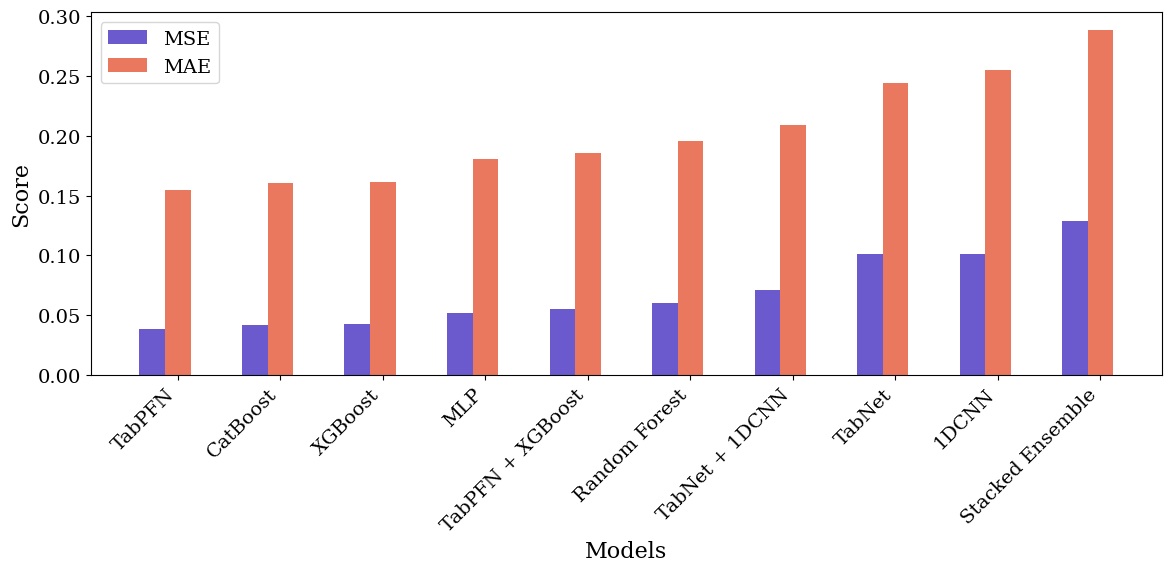

In [45]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np

# Data for the plots
models = ['Random Forest', 'CatBoost', 'XGBoost', 'MLP', 'TabNet', 'TabPFN', '1DCNN', 'TabNet + 1DCNN', 'TabPFN + XGBoost', 'Stacked Ensemble']
r2_scores = [r2_model1, r2_model2, r2_model3, r2_model4, r2_model5, r2_model6, r2_model7, r2_model8, r2_model9, r2_model10]
mse_scores = [mse_model1, mse_model2, mse_model3, mse_model4, mse_model5, mse_model6, mse_model7, mse_model8, mse_model9, mse_model10]
mae_scores = [mae_model1, mae_model2, mae_model3, mae_model4, mae_model5, mae_model6, mae_model7, mae_model8, mae_model9, mae_model10]
rmse_scores = [rmse_model1, rmse_model2, rmse_model3, rmse_model4, rmse_model5, rmse_model6, rmse_model7]

# Sort models by descending R²
sorted_indices = np.argsort(r2_scores)[::-1]
models_sorted = [models[i] for i in sorted_indices]
mse_sorted = [mse_scores[i] for i in sorted_indices]
mae_sorted = [mae_scores[i] for i in sorted_indices]

# Bar Graph: MSE, MAE, RMSE per model
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.weight"] = "regular"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

metrics = ['MSE', 'MAE']
scores = [mse_sorted, mae_sorted]

X_axis = np.arange(len(models_sorted))
width = 0.25

plt.figure(figsize=(12, 6))
colors = ['#6A5ACD', '#EA785F']  # Slate blue and tomato red

for i, metric in enumerate(metrics):
    plt.bar(X_axis + i * width, scores[i], width, label=metric, color=colors[i])

plt.xlabel("Models")
plt.ylabel("Score")
#plt.title("Comparison of MSE, MAE, and RMSE for Different Models")
plt.xticks(X_axis + width, models_sorted, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
